In [3]:
%%time
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import flotilla


csv_folder = '/home/obotvinnik/projects/singlecell_pnms/analysis/csvs_for_paper'
folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

metadata = pd.read_csv('{}/metadata.csv'.format(csv_folder), index_col=0)
expression = pd.read_csv('{}/expression.csv'.format(csv_folder), index_col=0)
mapping_stats = pd.read_csv('{}/mapping_stats.csv'.format(csv_folder), index_col=0)

splicing = pd.read_csv('{}/splicing.csv'.format(csv_folder), index_col=0)


print metadata.shape
print expression.shape
print mapping_stats.shape
print splicing.shape

(214, 9)
(214, 34608)
(214, 35)
(233, 25836)
CPU times: user 12.5 s, sys: 99 ms, total: 12.6 s
Wall time: 12.6 s


In [29]:
splicing_feature_data = pd.read_csv('{}/splicing_feature_data.csv'.format(folder), index_col=0)
print splicing_feature_data.shape
splicing_feature_data.head()

(33693, 24)


,criteria,criteria_additional,criteria_full,ensembl_id,exon1,exon1_length,exon2,exon2_length,exon3,exon3_length,...,intron_length,junction_exons12,junction_exons13,junction_exons23,junction_exons24,junction_exons34,strand,exon2_divisible_by_3,one_ensembl_id,splice_type
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100190328-100190427:-,100,exon:chr10:100189548-100189646:-,99,exon:chr10:100189330-100189399:-,70,...,928,chr10:100189647-100190327:-,chr10:100189400-100190327:-,chr10:100189400-100189547:-,NaN,NaN,-,True,ENSG00000107521,SE
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN,only one,ENSG00000107521,exon:chr10:100193697-100193848:-,152,exon:chr10:100190888-100191048:-,161,exon:chr10:100190328-100190427:-,100,...,3269,chr10:100191049-100193696:-,chr10:100190428-100193696:-,chr10:100190428-100190887:-,NaN,NaN,-,False,ENSG00000107521,SE
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100195392-100195529:-,138,exon:chr10:100195029-100195171:-,143,exon:chr10:100193697-100193848:-,152,...,1543,chr10:100195172-100195391:-,chr10:100193849-100195391:-,chr10:100193849-100195028:-,NaN,NaN,-,False,ENSG00000107521,SE
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN,only one,ENSG00000120053,exon:chr10:101165513-101165617:-,105,exon:chr10:101163481-101163631:-,151,exon:chr10:101163226-101163391:-,166,...,2121,chr10:101163632-101165512:-,chr10:101163392-101165512:-,chr10:101163392-101163480:-,NaN,NaN,-,False,ENSG00000120053,SE
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN,only one,ENSG00000198018,exon:chr10:101419263-101419345:+,83,exon:chr10:101419619-101419721:+,103,exon:chr10:101421203-101421385:+,183,...,1857,chr10:101419346-101419618:+,chr10:101419346-101421202:+,chr10:101419722-101421202:+,NaN,NaN,+,False,ENSG00000198018,SE


### Hack to adjust the SE splicing which is $1-\Psi$ instead of $\Psi$

Then glue MXE events onto the end. ONly SE events were affected...

In [42]:
se_events = splicing_feature_data.index[splicing_feature_data.splice_type == 'SE']
mxe_events = splicing_feature_data.index[splicing_feature_data.splice_type == 'MXE']

print splicing.shape
splicing_adjusted = 1-splicing.loc[:, se_events]
splicing_adjusted = pd.concat([splicing_adjusted, splicing.loc[:, mxe_events]], axis=1)
splicing_adjusted = splicing_adjusted.dropna(how='all', axis=1)
splicing_adjusted.shape

(233, 25836)


(233, 25836)

## Create a flotilla study!

2015-10-15 12:00:02	Initializing Study
2015-10-15 12:00:02	Initializing Predictor configuration manager for Study
2015-10-15 12:00:02	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-10-15 12:00:02	Added ExtraTreesClassifier to default predictors
2015-10-15 12:00:02	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-10-15 12:00:02	Added ExtraTreesRegressor to default predictors
2015-10-15 12:00:02	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-10-15 12:00:02	Added GradientBoostingClassifier to default predictors
2015-10-15 12:00:02	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2015-10-15 12:00:02	Added GradientBoostingRegressor to default predictors
2015-10-15 12:00:02	Loading metadata
2015-10-15 12:00:02	Loading species metadata from ~/f

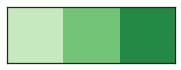

In [43]:
%matplotlib inline

greens = map(mpl.colors.rgb2hex, sns.color_palette('Greens', n_colors=3))
sns.palplot(greens)

lightgreen, mediumgreen, darkgreen = greens

phenotype_to_color = {'MN': greens[2],
                      'NPC': greens[1],
                      'iPSC': greens[0]}
phenotype_to_marker = {'MN': 's',    # square
                       'NPC': '^',   # Triangle
                       'iPSC': 'o'}  # circle
metadata_phenotype_order = ('iPSC', 'NPC', 'MN')

study = flotilla.Study(metadata, expression_data=expression, expression_log_base=2, 
                       expression_plus_one=True,
                       expression_thresh=1,
                       splicing_data=splicing_adjusted,
                      
                       # At least 20 samples per feature (either gene or splicing event)
                       metadata_minimum_samples=20, 
                       mapping_stats_data=mapping_stats,
                       mapping_stats_min_reads=1e6,
                       mapping_stats_number_mapped_col='Uniquely mapped reads number',
                       metadata_phenotype_order=('iPSC', 'NPC', 'MN'), 
                       metadata_phenotype_to_marker=phenotype_to_marker,
                       metadata_phenotype_to_color=phenotype_to_color,
                       species='hg19')

# Set the curated splicing feature data
study.splicing.feature_data = splicing_feature_data

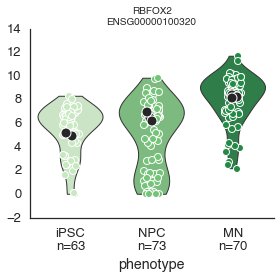

In [44]:
study.plot_gene('RBFOX2')

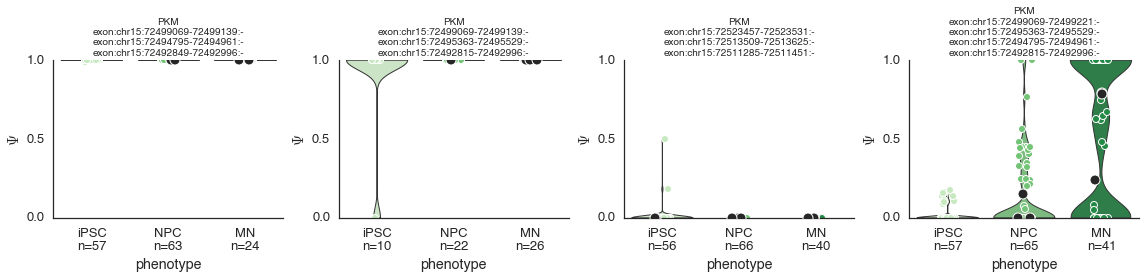

In [45]:
study.plot_event("PKM")

## Save the study!

In [46]:
study.save('singlecell_pnm')

Wrote datapackage to /home/obotvinnik/flotilla_projects/singlecell_pnm/datapackage.json


### Spot-check some genes

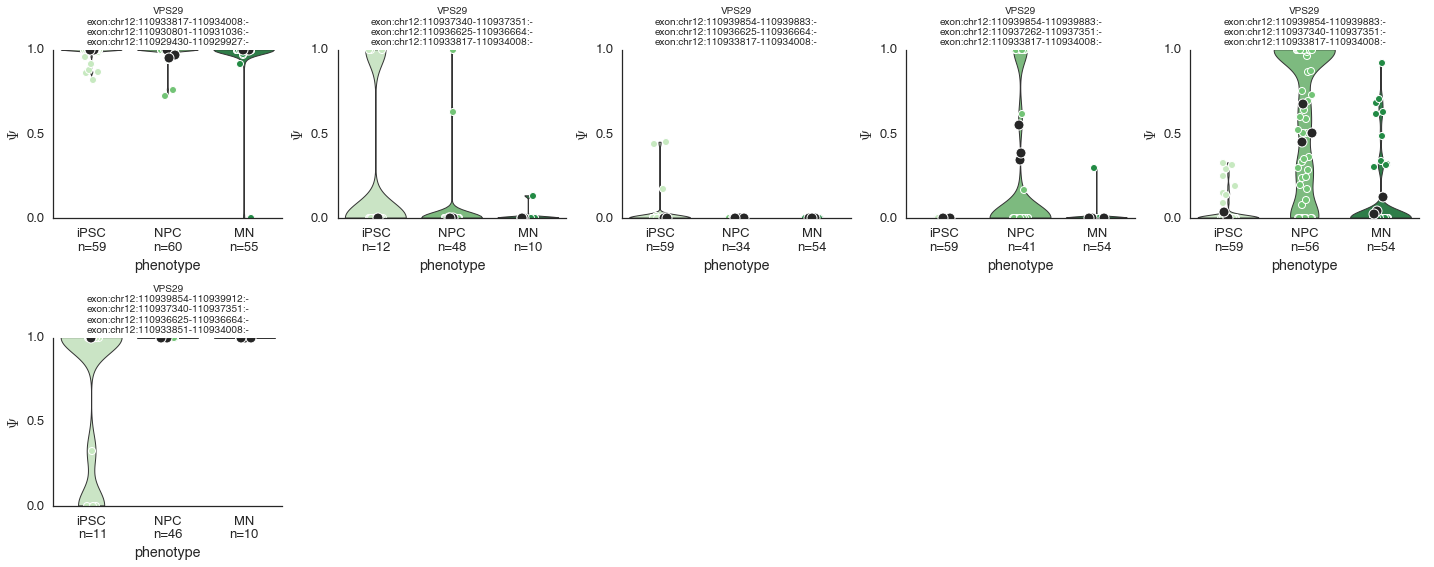

In [47]:
study.plot_event("VPS29")

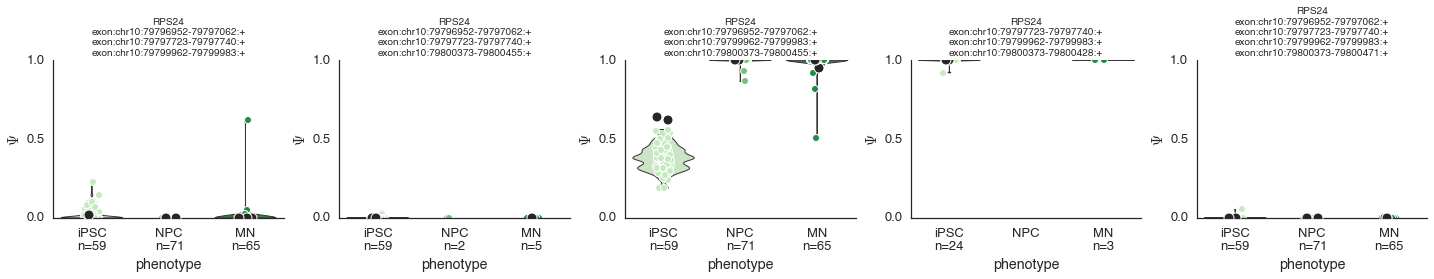

In [48]:
study.plot_event('RPS24')

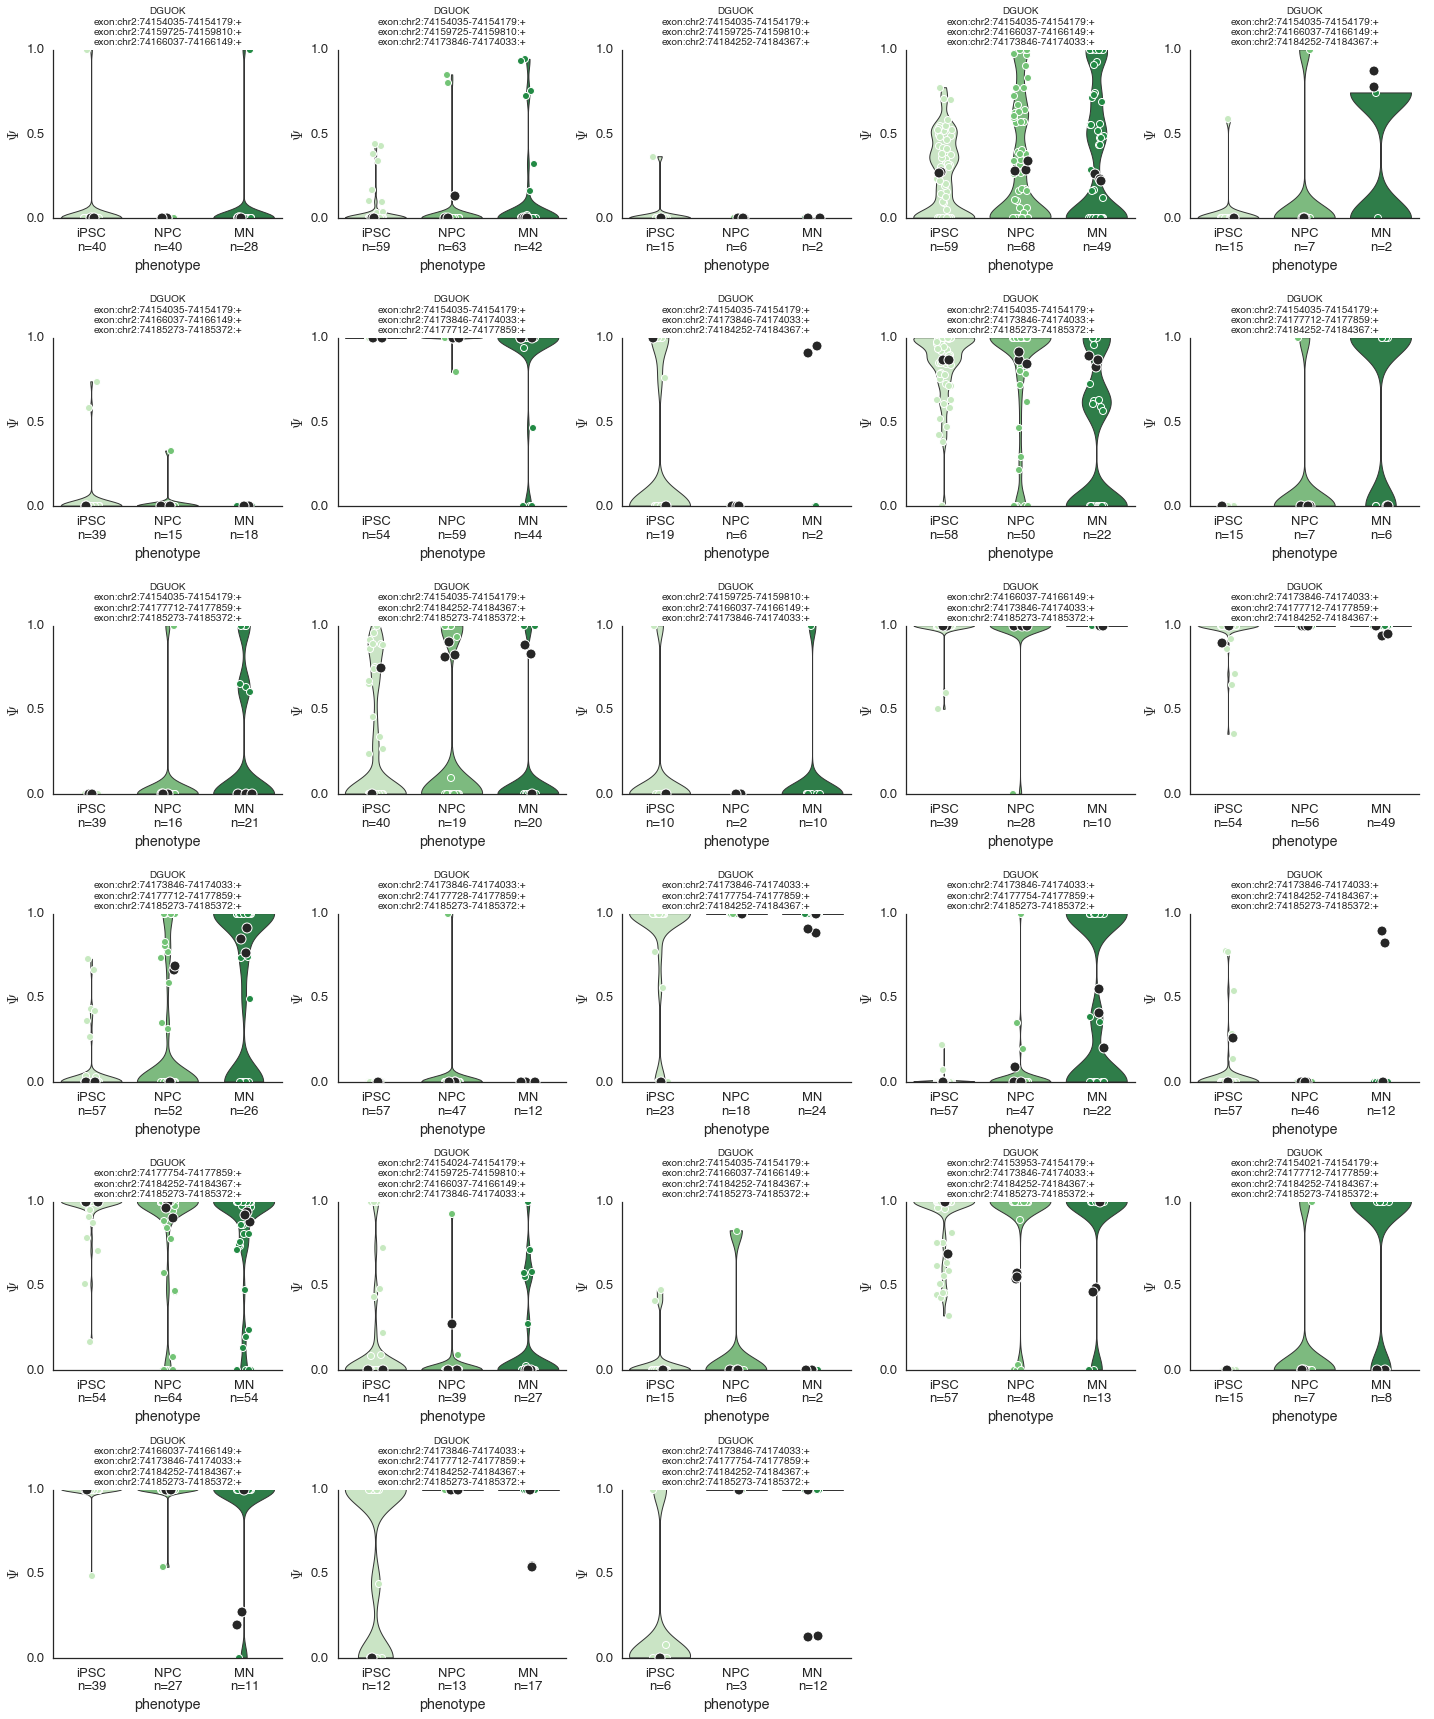

In [49]:
study.plot_event("DGUOK")

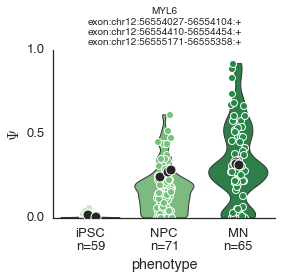

In [50]:
study.plot_event("MYL6")

In [51]:
study.splicing.maybe_renamed_to_feature_id('MYL6')

Index([u'exon:chr12:56554027-56554104:+@exon:chr12:56554410-56554454:+@exon:chr12:56555171-56555358:+'], dtype='object', name=u'event_id')

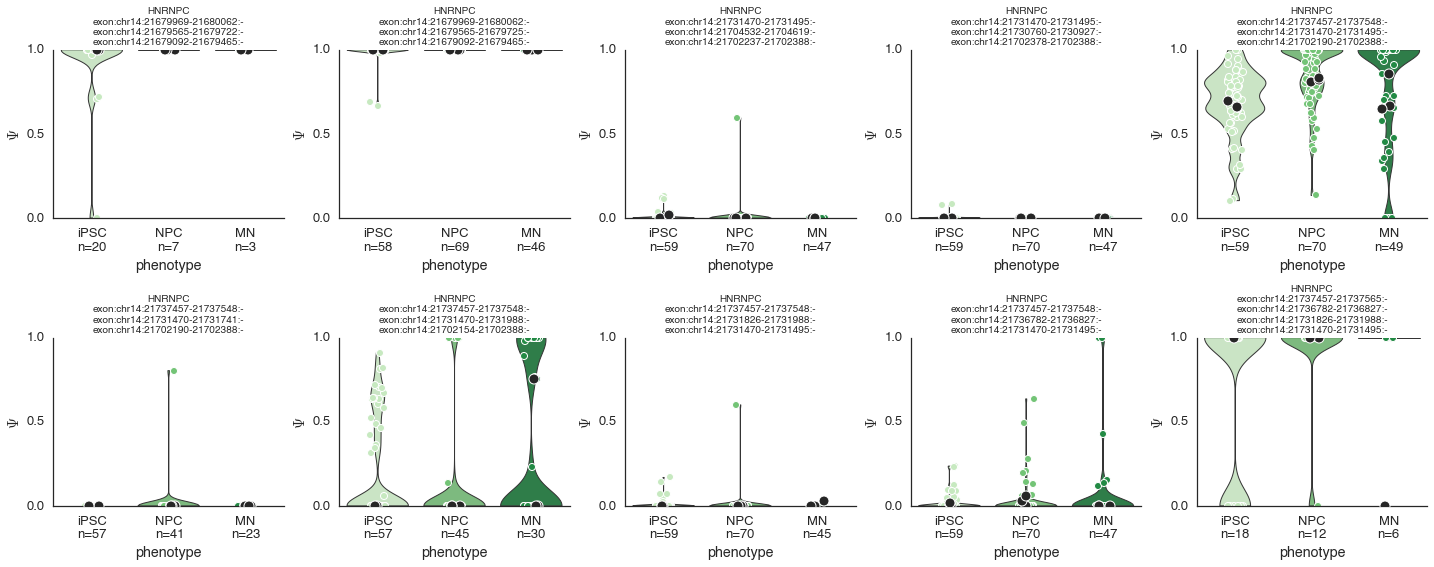

In [52]:
study.plot_event("HNRNPC")

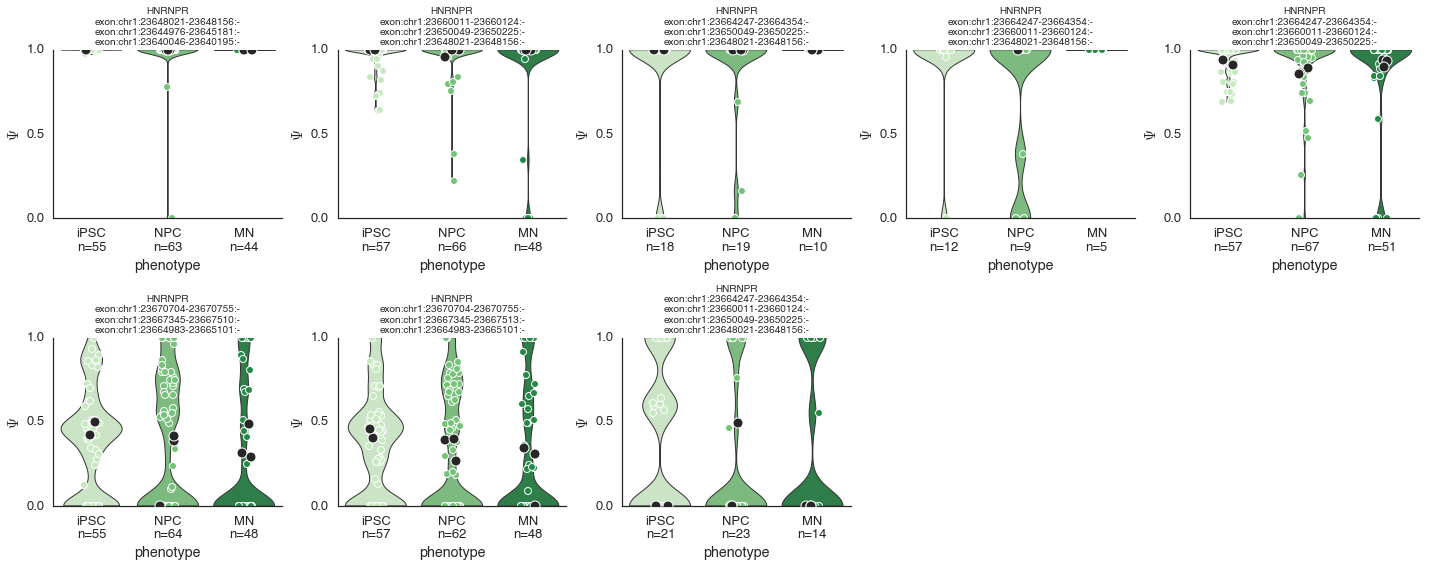

In [53]:
study.plot_event("HNRNPR")

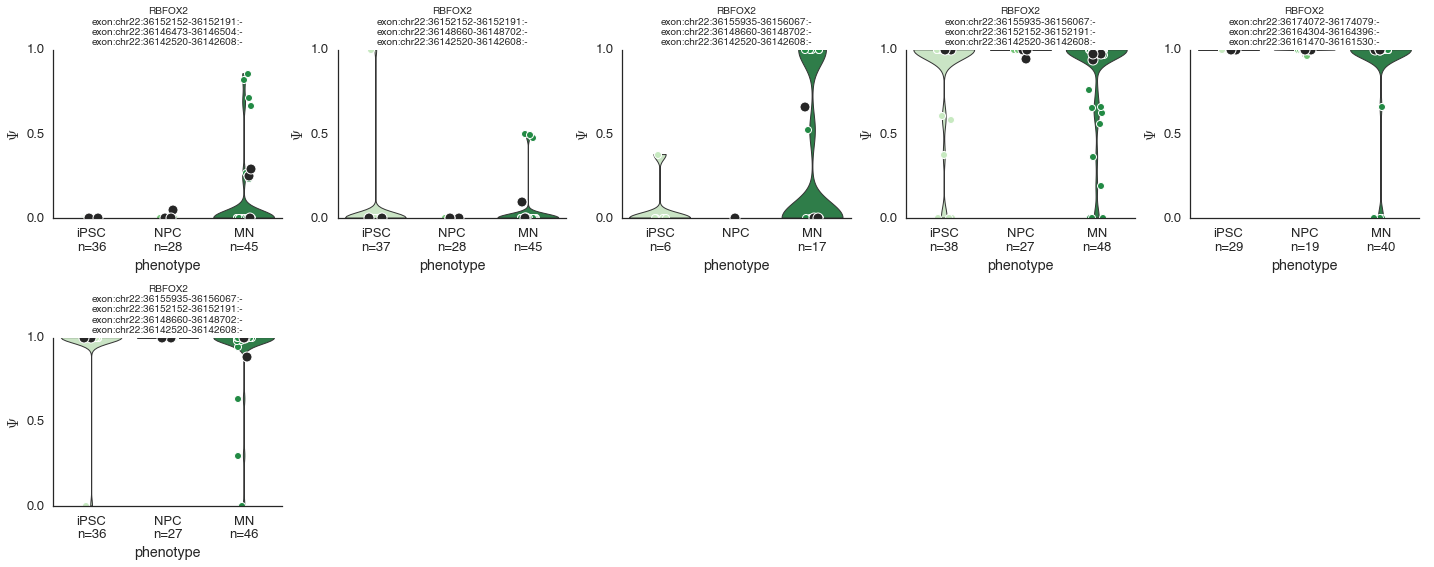

In [54]:
study.plot_event("RBFOX2")

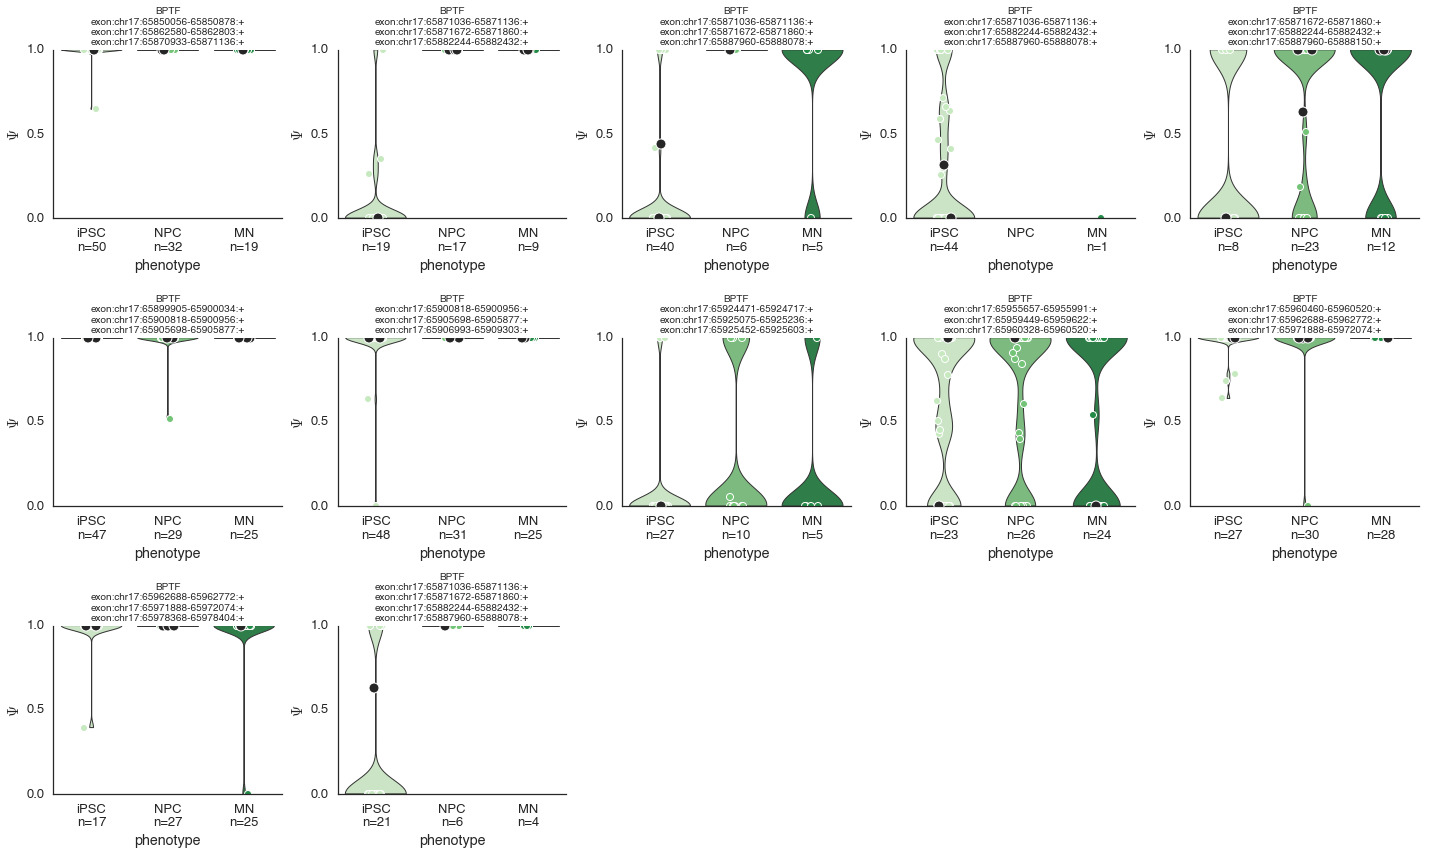

In [55]:
study.plot_event("BPTF")

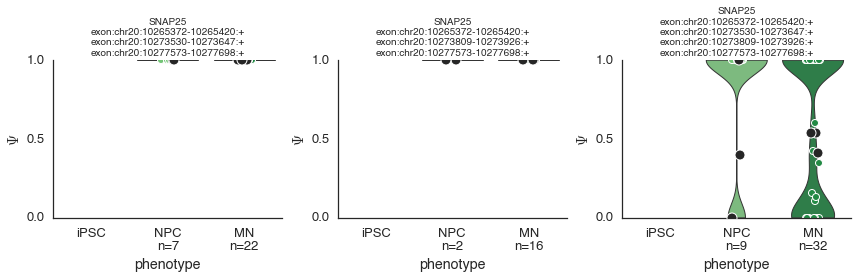

In [56]:
study.plot_event("SNAP25")

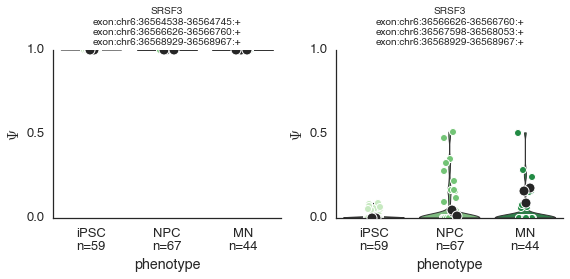

In [58]:
study.plot_event('SRSF3')

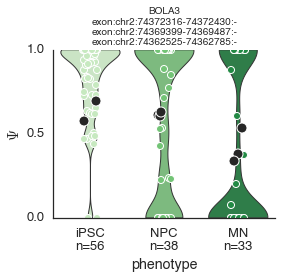

In [59]:
study.plot_event("BOLA3")